In [1]:
pip install yfinance

  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.7.tar.gz (939 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
   ---------------------------------------- 0.0/101.1 kB ? eta -:--:--
   ------------------------------------ --- 92.2/101.1 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 101.1/101.1 kB 1.9 MB/s eta 0:00:00
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
  Created wheel for peewee: filename=peewee-3.17.7-py3-none-any.whl size=138951 sha256=0b4ba2fe75dccc984d2e1da6b873f43accc2f6b9e7b1f7f5c1fcc2f7a


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import yfinance as yf
import pandas as pd
import os
import time

# 다운로드하려는 종목 목록
tickers = {
    "삼성전자": "005930.KS",
    "SK하이닉스": "000660.KS",
    "현대자동차": "005380.KS",
    "LG화학": "051910.KS",
    "NAVER": "035420.KS",
    # 필요한 만큼 추가 가능합니다
}

# 날짜 설정
train_start = "2000-01-01"
train_end = "2009-12-31"
test_start = "2010-01-01"
test_end = "2020-12-31"
save_path = "./stock_data"

# 디렉토리 생성 (존재하지 않으면)
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 함수 정의: 데이터를 다운로드하고 return 값을 계산한 후 CSV 파일로 저장
def download_and_save_data(ticker, company_name, train_start, train_end, test_start, test_end):
    # 2000-2009년 데이터를 train으로 저장
    try:
        train_data = yf.download(ticker, start=train_start, end=train_end, interval='1mo')
        train_data['Return'] = train_data['Adj Close'].pct_change()
        train_data = train_data.dropna()
        train_file = os.path.join(save_path, f"{company_name}_train.csv")
        train_data[['Adj Close', 'Return']].to_csv(train_file)
        print(f"{company_name} Train Data Saved.")
    except Exception as e:
        print(f"Error downloading train data for {ticker}: {e}")

    # 2010-2020년 데이터를 test로 저장
    try:
        test_data = yf.download(ticker, start=test_start, end=test_end, interval='1mo')
        test_data['Return'] = test_data['Adj Close'].pct_change()
        test_data = test_data.dropna()
        test_file = os.path.join(save_path, f"{company_name}_test.csv")
        test_data[['Adj Close', 'Return']].to_csv(test_file)
        print(f"{company_name} Test Data Saved.")
    except Exception as e:
        print(f"Error downloading test data for {ticker}: {e}")

# 각 회사에 대해 데이터를 다운로드하고 저장
for company_name, ticker in tickers.items():
    download_and_save_data(ticker, company_name, train_start, train_end, test_start, test_end)

print("데이터 다운로드 및 저장이 완료되었습니다.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

삼성전자 Train Data Saved.
삼성전자 Test Data Saved.
SK하이닉스 Train Data Saved.
SK하이닉스 Test Data Saved.
현대자동차 Train Data Saved.
현대자동차 Test Data Saved.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

LG화학 Train Data Saved.
LG화학 Test Data Saved.
NAVER Train Data Saved.
NAVER Test Data Saved.
데이터 다운로드 및 저장이 완료되었습니다.


c:\Anaconda\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


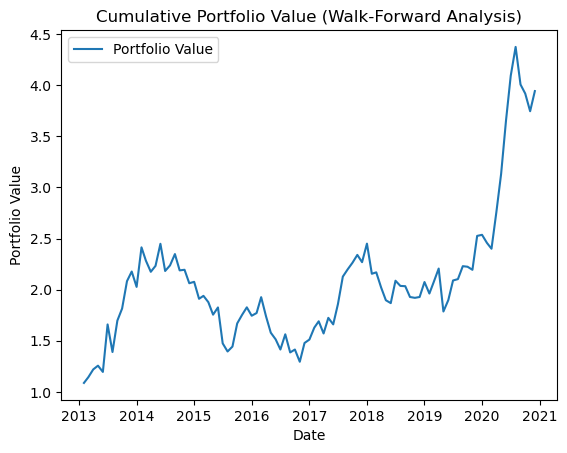

Mean Return: 0.22270574211302407
Volatility: 0.31820953859412204
Sharpe Ratio: 0.6998713586555506
Downside Deviation: 0.2686249957820175
Sortino Ratio: 0.8290581502465402
Max Drawdown: 1.1542772288961134
Calmar Ratio: 0.19293956125774694

Additional Metrics:
Cumulative Return: 2.942829479737574
Annualized Return: 0.22270574211302407
Annualized Standard Deviation (SD): 0.31820953859412204
Sharpe Ratio: 0.6370196915170929


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize
import os

# 데이터 로드 및 로그 수익률 계산
def load_data(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('_train.csv') or f.endswith('_test.csv')]
    data = {}

    for file in files:
        company_name = file.split('_')[0]  # 파일명에서 종목명 추출
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        if company_name not in data:
            data[company_name] = df['Return']
        else:
            data[company_name] = pd.concat([data[company_name], df['Return']])
    
    combined_data = pd.DataFrame(data)
    log_returns = np.log(1 + combined_data)
    log_returns = log_returns.dropna()  # 결측치 제거
    return log_returns

# GARCH 모델을 이용한 분산-공분산 행렬 계산
# def garch_cov_matrix(log_returns):
#     n_assets = log_returns.shape[1]
#     garch_volatilities = []

#     for i in range(n_assets):
#         model = arch_model(log_returns.iloc[:, i], vol='Garch', p=1, q=1)
#         garch_fit = model.fit(disp="off")
#         # 평균 조건부 변동성을 사용하여 분산-공분산 행렬 생성
#         garch_volatilities.append(garch_fit.conditional_volatility.mean())

#     # 자산별 평균 조건부 변동성으로 분산-공분산 행렬 계산
#     volatilities = np.diag(garch_volatilities)
#     cov_matrix = pd.DataFrame(volatilities).cov()
#     return cov_matrix
def garch_cov_matrix(log_returns):
    # 상관 행렬 계산
    correlation_matrix = log_returns.corr()

    # GARCH(1,1) 모델로 각 자산의 분산 추정
    n_assets = len(log_returns.columns)
    variance_dict = {}
    for asset in log_returns.columns:
        model = arch_model(log_returns[asset], vol='Garch', p=1, q=1, rescale=False)
        results = model.fit(disp='off')
        variance_dict[asset] = results.forecast(start=0).variance.iloc[-1, 0]

    # variance_dict를 데이터프레임으로 변환
    variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance'])

    # 공분산 행렬 계산
    std_dev = np.sqrt(variance_df['variance'])
    covariance_matrix = correlation_matrix.mul(std_dev, axis=0).mul(std_dev, axis=1)

    return covariance_matrix.values

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율) # 위험 대비 수익 극대화
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(log_returns, initial_train_period=120, step_size=12):
    all_weights = []
    portfolio_returns = []

    for start in range(initial_train_period, len(log_returns), step_size):
        train_data = log_returns.iloc[start-initial_train_period:start]
        test_data = log_returns.iloc[start:start+step_size]

        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

    portfolio_returns = pd.concat(portfolio_returns)
    return portfolio_returns, all_weights

# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)
    
    sortino_ratio = mean_return / downside_deviation
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()
    calmar_ratio = mean_return / max_drawdown

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }
    return metrics

# 데이터 로드 및 Walk-Forward Analysis 실행
folder_path = "./stock_data"
log_returns = load_data(folder_path)
portfolio_returns, portfolio_weights = walk_forward_analysis(log_returns)

# 누적 수익률 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

# 추가 메트릭스 계산
cumulative_return = (1 + portfolio_returns).prod() - 1
annualized_return = portfolio_returns.mean() * 12
annualized_sd = portfolio_returns.std() * np.sqrt(12)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

print("\nAdditional Metrics:")
print("Cumulative Return:", cumulative_return)
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation (SD):", annualized_sd)
print("Sharpe Ratio:", sharpe_ratio)

c:\Anaconda\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


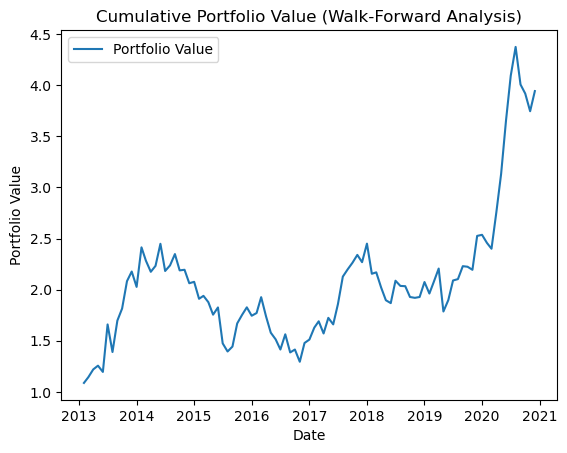

Mean Return: 0.22270574211302407
Volatility: 0.31820953859412204
Sharpe Ratio: 0.6998713586555506
Downside Deviation: 0.2686249957820175
Sortino Ratio: 0.8290581502465402
Max Drawdown: 1.1542772288961134
Calmar Ratio: 0.19293956125774694

Additional Metrics:
Cumulative Return: Date
2013-02-01 00:00:00+00:00    1.087357
2013-03-01 00:00:00+00:00    1.143751
2013-04-01 00:00:00+00:00    1.219630
2013-05-01 00:00:00+00:00    1.256161
2013-06-01 00:00:00+00:00    1.194975
                               ...   
2020-08-01 00:00:00+00:00    4.374838
2020-09-01 00:00:00+00:00    4.007107
2020-10-01 00:00:00+00:00    3.918284
2020-11-01 00:00:00+00:00    3.745644
2020-12-01 00:00:00+00:00    3.942829
Length: 95, dtype: float64
Annualized Return: 0.18921384660145746
Annualized Standard Deviation (SD): 0.31820953859412204
Sharpe Ratio: 0.5317686180906431


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize
import os

# 데이터 로드 및 로그 수익률 계산
def load_data(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('_train.csv') or f.endswith('_test.csv')]
    data = {}

    for file in files:
        company_name = file.split('_')[0]  # 파일명에서 종목명 추출
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        
        if company_name not in data:
            data[company_name] = df['Return']
        else:
            data[company_name] = pd.concat([data[company_name], df['Return']])
    
    combined_data = pd.DataFrame(data)
    log_returns = np.log(1 + combined_data)
    log_returns = log_returns.dropna()  # 결측치 제거
    return log_returns

# GARCH 모델을 이용한 분산-공분산 행렬 계산
def garch_cov_matrix(log_returns):
    # 상관 행렬 계산
    correlation_matrix = log_returns.corr()

    # GARCH(1,1) 모델로 각 자산의 분산 추정
    n_assets = len(log_returns.columns)
    variance_dict = {}
    for asset in log_returns.columns:
        model = arch_model(log_returns[asset], vol='Garch', p=1, q=1, rescale=False)
        results = model.fit(disp='off')
        variance_dict[asset] = results.forecast(start=0).variance.iloc[-1, 0]

    # variance_dict를 데이터프레임으로 변환
    variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance'])

    # 공분산 행렬 계산
    std_dev = np.sqrt(variance_df['variance'])
    covariance_matrix = correlation_matrix.mul(std_dev, axis=0).mul(std_dev, axis=1)

    return covariance_matrix.values

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율) # 위험 대비 수익 극대화
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(log_returns, initial_train_period=120, step_size=12):
    all_weights = []
    portfolio_returns = []

    for start in range(initial_train_period, len(log_returns), step_size):
        train_data = log_returns.iloc[start-initial_train_period:start]
        test_data = log_returns.iloc[start:start+step_size]

        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

    portfolio_returns = pd.concat(portfolio_returns)
    return portfolio_returns, all_weights

# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)
    
    sortino_ratio = mean_return / downside_deviation
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()
    calmar_ratio = mean_return / max_drawdown

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }
    return metrics

# 데이터 로드 및 Walk-Forward Analysis 실행
folder_path = "./stock_data"
log_returns = load_data(folder_path)
portfolio_returns, portfolio_weights = walk_forward_analysis(log_returns)

# 누적 수익률 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

# 추가 메트릭스 계산
#annualized_return = portfolio_returns.mean() * 12
annualized_return = ((1 + portfolio_returns).prod() ** (12 / len(portfolio_returns))) - 1
annualized_sd = portfolio_returns.std() * np.sqrt(12)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

print("\nAdditional Metrics:")
print("Cumulative Return:", cumulative_returns)
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation (SD):", annualized_sd)
print("Sharpe Ratio:", sharpe_ratio)

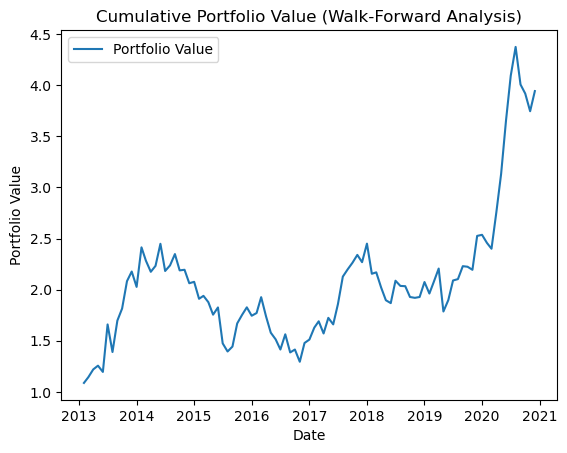

Mean Return: 0.22270574211302407
Volatility: 0.31820953859412204
Sharpe Ratio: 0.6998713586555506
Downside Deviation: 0.2686249957820175
Sortino Ratio: 0.8290581502465402
Max Drawdown: 1.1542772288961134
Calmar Ratio: 0.19293956125774694

Additional Metrics:
Cumulative Return: 2.942829479737574
Annualized Return: 0.18921384660145746
Annualized Standard Deviation (SD): 0.31820953859412204
Sharpe Ratio: 0.5317686180906431


In [13]:
# 누적 수익률 시각화
cumulative_portfolio_value = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_portfolio_value, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

# 추가 메트릭스 계산
annualized_return = ((1 + portfolio_returns).prod() ** (12 / len(portfolio_returns))) - 1
annualized_sd = portfolio_returns.std() * np.sqrt(12)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

print("\nAdditional Metrics:")
print("Cumulative Return:", cumulative_portfolio_value.iloc[-1] - 1)  # 누적 수익률
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation (SD):", annualized_sd)
print("Sharpe Ratio:", sharpe_ratio)

c:\Anaconda\Lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


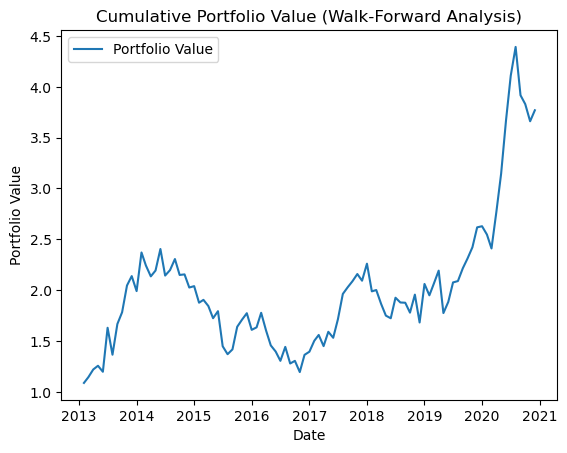

Mean Return: 0.22055099734929717
Volatility: 0.328619381111418
Sharpe Ratio: 0.6711442173720108
Downside Deviation: 0.2937767607155263
Sortino Ratio: 0.7507435129045622
Max Drawdown: 1.2107721193057133
Calmar Ratio: 0.1821573141903586

Additional Metrics:
Cumulative Return: 2.7696658173604884
Annualized Return: 0.22055099734929717
Annualized Standard Deviation (SD): 0.328619381111418
Sharpe Ratio: 0.6102835343156484


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize
import os

# 데이터 로드 및 로그 수익률 계산
def load_data(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith('_train.csv') or f.endswith('_test.csv')]
    data = {}

    for file in files:
        company_name = file.split('_')[0]  # 파일명에서 종목명 추출
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
        df.index = df.index.tz_localize(None)  # 인덱스에서 시간대 제거
        
        if company_name not in data:
            data[company_name] = df['Return']
        else:
            data[company_name] = pd.concat([data[company_name], df['Return']])
    
    combined_data = pd.DataFrame(data)
    log_returns = np.log(1 + combined_data)
    log_returns = log_returns.dropna()  # 결측치 제거
    return log_returns

# GARCH 모델을 이용한 분산-공분산 행렬 계산
# def garch_cov_matrix(log_returns):
#     n_assets = log_returns.shape[1]
#     garch_volatilities = []

#     for i in range(n_assets):
#         model = arch_model(log_returns.iloc[:, i], vol='Garch', p=1, q=1)
#         garch_fit = model.fit(disp="off")
#         # 평균 조건부 변동성을 사용하여 분산-공분산 행렬 생성
#         garch_volatilities.append(garch_fit.conditional_volatility.mean())

#     # 자산별 평균 조건부 변동성으로 분산-공분산 행렬 계산
#     volatilities = np.diag(garch_volatilities)
#     cov_matrix = pd.DataFrame(volatilities).cov()
#     return cov_matrix
def garch_cov_matrix(log_returns):
    # 상관 행렬 계산
    correlation_matrix = log_returns.corr()

    # GARCH(1,1) 모델로 각 자산의 분산 추정
    n_assets = len(log_returns.columns)
    variance_dict = {}
    for asset in log_returns.columns:
        model = arch_model(log_returns[asset], vol='Garch', p=1, q=1, rescale=False)
        results = model.fit(disp='off')
        variance_dict[asset] = results.forecast(start=0).variance.iloc[-1, 0]

    # variance_dict를 데이터프레임으로 변환
    variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance'])

    # 공분산 행렬 계산
    std_dev = np.sqrt(variance_df['variance'])
    covariance_matrix = correlation_matrix.mul(std_dev, axis=0).mul(std_dev, axis=1)

    return covariance_matrix.values

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율) # 위험 대비 수익 극대화
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(log_returns, initial_train_period=120, step_size=1):
    all_weights = []
    portfolio_returns = []
    
    end_date = pd.Timestamp('2021-01-01').tz_localize(None)  # tz-naive로 설정
    
    current_end_train = initial_train_period

    while current_end_train + step_size <= len(log_returns) and log_returns.index[current_end_train + step_size - 1] < end_date:
        # Define train and test periods
        train_data = log_returns.iloc[current_end_train - initial_train_period:current_end_train]
        test_data = log_returns.iloc[current_end_train:current_end_train + step_size]

        # Compute GARCH-based covariance matrix
        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()

        # Optimize portfolio for maximum Sharpe ratio
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        # Compute portfolio return for test period
        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

        # Move to next step
        current_end_train += step_size

    portfolio_returns = pd.concat(portfolio_returns)
    return portfolio_returns, all_weights

# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)
    
    sortino_ratio = mean_return / downside_deviation
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()
    calmar_ratio = mean_return / max_drawdown

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }
    return metrics

# 데이터 로드 및 Walk-Forward Analysis 실행
folder_path = "./stock_data"
log_returns = load_data(folder_path)
portfolio_returns, portfolio_weights = walk_forward_analysis(log_returns)

# 누적 수익률 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

# 추가 메트릭스 계산
cumulative_return = (1 + portfolio_returns).prod() - 1
annualized_return = portfolio_returns.mean() * 12
annualized_sd = portfolio_returns.std() * np.sqrt(12)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

print("\nAdditional Metrics:")
print("Cumulative Return:", cumulative_return)
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation (SD):", annualized_sd)
print("Sharpe Ratio:", sharpe_ratio)

[*********************100%***********************]  1 of 1 completed


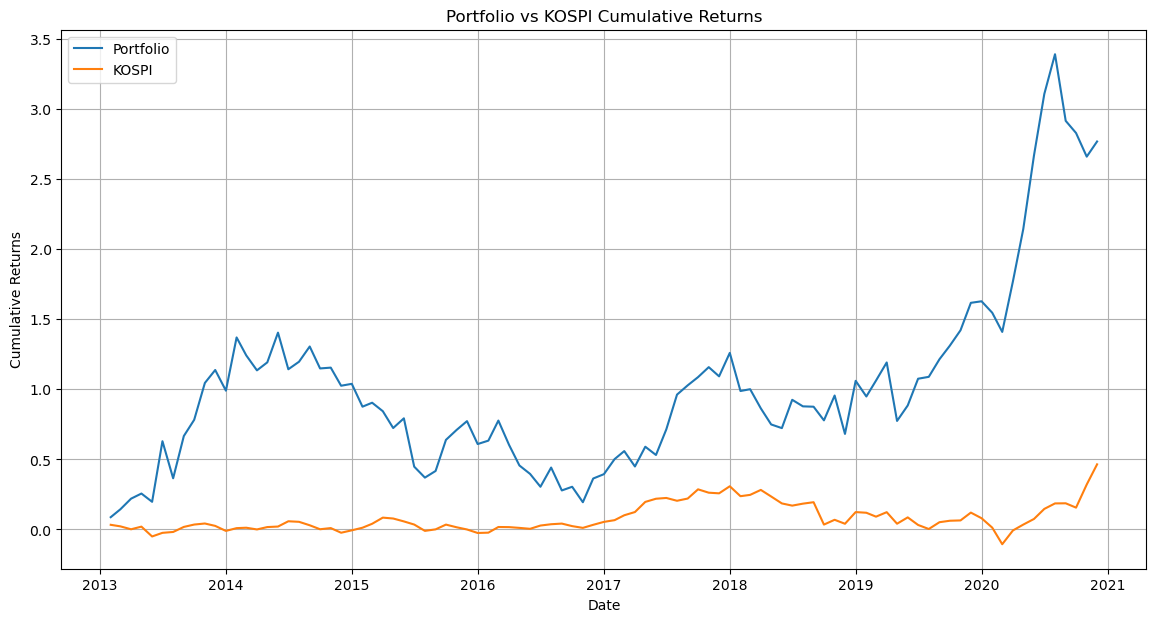

In [26]:
import matplotlib.pyplot as plt

# 포트폴리오 누적 수익률 시계열 계산
cumulative_returns = (1 + portfolio_returns).cumprod() - 1  # 누적 수익률 시계열 계산
portfolio_df = pd.DataFrame(cumulative_returns, columns=['Cumulative Returns'])
portfolio_df.index = portfolio_returns.index  # 포트폴리오와 동일한 날짜 인덱스 설정

# KOSPI 지수 데이터 다운로드
import yfinance as yf
kospi = yf.download('^KS11', start='2013-01-01', end='2020-12-31', interval='1mo')

# 월별 누적 수익률 계산
kospi['Monthly Returns'] = kospi['Adj Close'].pct_change()
kospi['Cumulative Returns'] = (1 + kospi['Monthly Returns']).cumprod() - 1

# 포트폴리오와 KOSPI 누적 수익률 시각화
plt.figure(figsize=(14, 7))
plt.plot(portfolio_df.index, portfolio_df['Cumulative Returns'], label='Portfolio')
plt.plot(kospi.index, kospi['Cumulative Returns'], label='KOSPI')
plt.title('Portfolio vs KOSPI Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


Original Code

In [1]:
import yfinance as yf
import pandas as pd
import time

# 다운로드하려는 종목 목록
tickers = ["005490.KS", "015760.KS", "017670.KS", "005930.KS", "000660.KS",
           "005380.KS", "055550.KS", "004020.KS", "010950.KS", "009540.KS",
           "000720.KS", "033780.KS", "010130.KS", "012330.KS" ]  # 여기에서 더 많은 종목 추가 가능

# 빈 데이터프레임 생성
data = pd.DataFrame()

# 각 종목의 데이터를 다운로드하고 Adj Close만 저장
for ticker in tickers:
    success = False
    retries = 5  # 재시도 횟수
    while not success and retries > 0:
        try:
            print(f"Downloading data for {ticker}...")
            stock_data = yf.download(ticker, start="2000-01-01", end="2020-12-31", interval="1mo", timeout=10)
            adj_close = stock_data[['Adj Close']].copy()  # Adj Close 열만 선택
            adj_close = adj_close.tz_convert(None)  # 타임존 제거
            adj_close.columns = [ticker]  # 열 이름을 종목명으로 변경
            data = pd.concat([data, adj_close], axis=1)  # 가로로 합치기
            success = True  # 성공 시 반복 중지
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")
            retries -= 1
            time.sleep(5)  # 재시도 전 대기 시간 설정

# 결측치 확인
if data.isnull().values.any():
    print("Missing values detected in the data. Check for gaps.")

# 데이터 확인
print(data.head())

# 엑셀로 저장
data.to_excel("stock_data_2000_2020_0.xlsx", index=True)  # 날짜를 인덱스로 유지
print("Data saved to stock_data_2000_2020_0.xlsx")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


               005490.KS     015760.KS     017670.KS    005930.KS  \
Date                                                                
2000-02-01  63761.910156  18063.109375  27671.779297  3712.168701   
2000-03-01  60902.625000  20105.578125  23718.658203  4857.721191   
2000-04-01  49637.105469  20743.851562  19436.125000  4350.198730   
2000-05-01  48607.757812  19339.652344  25365.787109  4466.203613   
2000-06-01  54097.570312  22084.224609  24048.085938  5350.744141   

                000660.KS    005380.KS    055550.KS    004020.KS    010950.KS  \
Date                                                                            
2000-02-01 -161356.406250  6731.826172  5525.087402  2882.801025  4362.905273   
2000-03-01 -221752.359375  7486.011230  4693.983887  3079.355469  4732.250488   
2000-04-01 -158652.062500  5837.971680  4775.923340  2057.271240  4743.793945   
2000-05-01 -158652.062500  6759.759277  6098.667480  2194.859863  4328.278809   
2000-06-01 -198315.109375  798

In [2]:
import pandas as pd

# 데이터 불러오기
data = pd.read_excel('stock_data_2000_2020_0.xlsx', header=0)  # 헤더가 단일일 경우
data.set_index('Date', inplace=True)  # 'Date' 열을 인덱스로 설정

# 숫자 데이터를 처리하기 위해 필요한 경우 숫자형으로 변환
data = data.apply(pd.to_numeric, errors='coerce')

# 수익률 계산 (각 달의 퍼센트 변화 계산)
returns = data.pct_change().dropna()

# 결과 확인
print(returns.head())

            005490.KS  015760.KS  017670.KS  005930.KS  000660.KS  005380.KS  \
Date                                                                           
2000-03-01  -0.044843   0.113074  -0.142857   0.308594   0.374302   0.112033   
2000-04-01  -0.184976   0.031746  -0.180556  -0.104477  -0.284553  -0.220149   
2000-05-01  -0.020738  -0.067692   0.305085   0.026667   0.000000   0.157895   
2000-06-01   0.112942   0.141914  -0.051948   0.198052   0.250000   0.181819   
2000-07-01  -0.069768  -0.069364  -0.238356  -0.200542  -0.209091   0.045454   

            055550.KS  004020.KS  010950.KS  009540.KS  000720.KS  033780.KS  \
Date                                                                           
2000-03-01  -0.150423   0.068182   0.084656   0.025397  -0.055838  -0.128159   
2000-04-01   0.017456  -0.331915   0.002439  -0.294118   0.088710  -0.118012   
2000-05-01   0.276961   0.066879  -0.087591  -0.074562  -0.151852  -0.037559   
2000-06-01   0.381958   0.044776   0.42

In [3]:
returns.to_excel("stock_data_2000_2020_1.xlsx", index=True)

Portfolio Optimization

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize

In [14]:
# 음수 값 확인 및 제거
returns = returns.dropna()  # 결측치 제거

# 로그 수익률 계산
log_returns = np.log(1 + returns)

# # Train 데이터와 Test 데이터 나누기
# train_returns = returns["2000-01-01":"2009-12-31"]
# test_returns = returns["2010-01-01":"2020-12-31"]

NEW CODE

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may

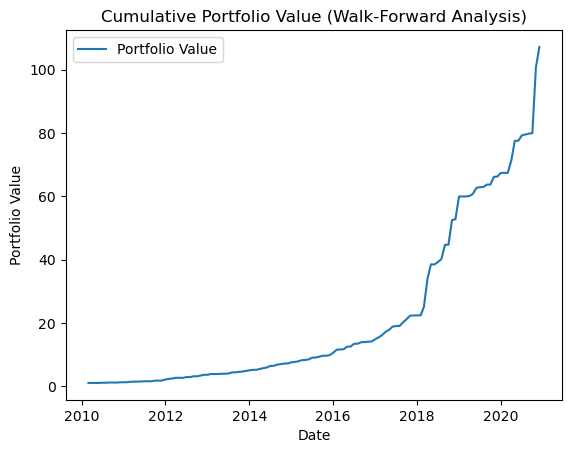

Mean Return: 0.45377074992881816
Volatility: 0.1808967269464156
Sharpe Ratio: 2.508451963662295
Downside Deviation: nan
Sortino Ratio: nan
Max Drawdown: 0.0
Calmar Ratio: inf


C:\Users\김수빈\AppData\Local\Temp\ipykernel_1036\2108778183.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  calmar_ratio = mean_return / max_drawdown


In [15]:
# Train 기간과 Test 기간 나누기
initial_train_period = 120  # 처음 10년(120개월)을 Train 데이터로 사용
step_size = 12  # 매년 Walk-Forward Test를 진행 (1년 간격)

# GARCH 모델을 이용한 분산-공분산 행렬 계산
def garch_cov_matrix(log_returns):
    n_assets = log_returns.shape[1]
    garch_models = []
    for i in range(n_assets):
        model = arch_model(log_returns.iloc[:, i], vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp="off")
        garch_models.append(garch_fit.conditional_volatility)

    volatilities = pd.DataFrame(garch_models).T
    cov_matrix = volatilities.cov()
    return cov_matrix

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율)
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 가중치 합이 1이 되어야 함
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))  # 가중치는 0에서 1 사이
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(log_returns, initial_train_period, step_size):
    all_weights = []
    portfolio_returns = []

    # Rolling 윈도우 방식으로 테스트 및 리밸런싱 수행
    for start in range(initial_train_period, len(log_returns), step_size):
        # Train 데이터는 step_size 만큼 추가됨
        train_data = log_returns.iloc[start-initial_train_period:start]
        test_data = log_returns.iloc[start:start+step_size]

        # Train 데이터로 분산-공분산 행렬과 기대 수익률 계산
        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()

        # 최적화된 포트폴리오 가중치 계산
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        # 테스트 데이터로 포트폴리오 수익률 계산
        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

    # 수익률 연결
    portfolio_returns = pd.concat(portfolio_returns)

    return portfolio_returns, all_weights

# 백테스팅 실행
portfolio_returns, portfolio_weights = walk_forward_analysis(log_returns, initial_train_period, step_size)

# 누적 수익률 계산 및 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility
    # 샤프 비율 계산
    # sharpe_ratio = mean_return / volatility if volatility != 0 else np.nan

    # Downside Deviation 계산
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)

    # Sortino Ratio 계산
    sortino_ratio = mean_return / downside_deviation
    
    # if len(downside_returns) > 0:
    #     downside_deviation = np.sqrt((downside_returns ** 2).mean()) * np.sqrt(12)
    #     sortino_ratio = mean_return / downside_deviation if downside_deviation != 0 else np.nan
    # else:
    #     downside_deviation = 0.0
    #     sortino_ratio = np.nan  # 음수 수익률이 없으면 Sortino Ratio는 정의되지 않음

    # Maximum Drawdown 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    # drawdown = (running_max - cumulative_returns) / running_max
    max_drawdown = drawdown.max()
    # max_drawdown = drawdown.max() if not drawdown.empty else np.nan

    # Calmar Ratio 계산
    calmar_ratio = mean_return / max_drawdown
    # calmar_ratio = mean_return / max_drawdown if max_drawdown != 0 else np.nan

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

    return metrics

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

In [16]:
# Cumulative Return 계산
cumulative_return = (1 + portfolio_returns).prod() - 1

# Annualized Return 계산
annualized_return = portfolio_returns.mean() * 12

# Annualized Standard Deviation (SD) 계산
annualized_sd = portfolio_returns.std() * np.sqrt(12)

# Sharpe Ratio 계산 (무위험 수익률을 2%로 가정)
risk_free_rate = 0.02
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

# 결과 출력
print("Cumulative Return:", cumulative_return)
print("Annualized Return:", annualized_return)
print("Annualized Standard Deviation (SD):", annualized_sd)
print("Sharpe Ratio:", sharpe_ratio)

Cumulative Return: 106.21598455170255
Annualized Return: 0.45377074992881816
Annualized Standard Deviation (SD): 0.1808967269464156
Sharpe Ratio: 2.397891643762619


c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001865. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may

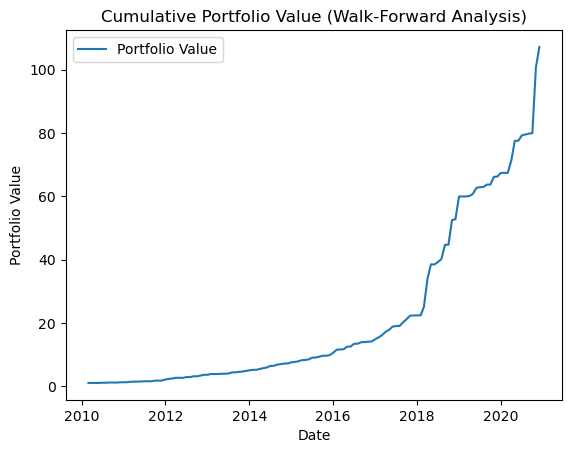

Cumulative Return: 106.21598455170255
Annualized Return: 0.45377074992881816
Annualized SD: 0.1808967269464156
Sharpe Ratio: 2.397891643762619
Downside Deviation: nan
Sortino Ratio: nan
Max Drawdown: 0.0
Calmar Ratio: nan


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize

# 결측치 제거
returns = returns.dropna()

# 로그 수익률 계산
log_returns = np.log(1 + returns)

# Train 기간과 Test 기간 나누기
initial_train_period = 120  # 처음 10년(120개월)을 Train 데이터로 사용
step_size = 12  # 매년 Walk-Forward Test를 진행 (1년 간격)

# GARCH 모델을 이용한 분산-공분산 행렬 계산
def garch_cov_matrix(log_returns):
    n_assets = log_returns.shape[1]
    garch_models = []
    for i in range(n_assets):
        model = arch_model(log_returns.iloc[:, i], vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp="off")
        garch_models.append(garch_fit.conditional_volatility)

    volatilities = pd.DataFrame(garch_models).T
    cov_matrix = volatilities.cov()
    return cov_matrix

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율)
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(log_returns, initial_train_period, step_size):
    all_weights = []
    portfolio_returns = []

    for start in range(initial_train_period, len(log_returns), step_size):
        train_data = log_returns.iloc[start-initial_train_period:start]
        test_data = log_returns.iloc[start:start+step_size]

        # Train 데이터로 분산-공분산 행렬과 기대 수익률 계산
        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()

        # 최적화된 포트폴리오 가중치 계산
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        # 테스트 데이터로 포트폴리오 수익률 계산
        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

    portfolio_returns = pd.concat(portfolio_returns)
    return portfolio_returns, all_weights

# 백테스팅 실행
portfolio_returns, portfolio_weights = walk_forward_analysis(log_returns, initial_train_period, step_size)

# 누적 수익률 계산 및 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 계산 함수
def calculate_metrics(portfolio_returns, risk_free_rate=0.02):
    cumulative_return = (1 + portfolio_returns).prod() - 1
    annualized_return = portfolio_returns.mean() * 12
    annualized_sd = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_sd

    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else np.nan

    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (running_max - cumulative_returns) / running_max
    max_drawdown = drawdown.max() if not drawdown.empty else np.nan

    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.nan

    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized SD": annualized_sd,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

    return metrics

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")


Benchmark(KOSPI)

In [10]:
# 포트폴리오 누적 수익률 계산
portfolio_df = pd.DataFrame((1 + portfolio_returns).cumprod(), columns=['Cumulative Returns'])
portfolio_df.index = portfolio_returns.index  # 포트폴리오와 동일한 날짜 인덱스 설정

[*********************100%***********************]  1 of 1 completed


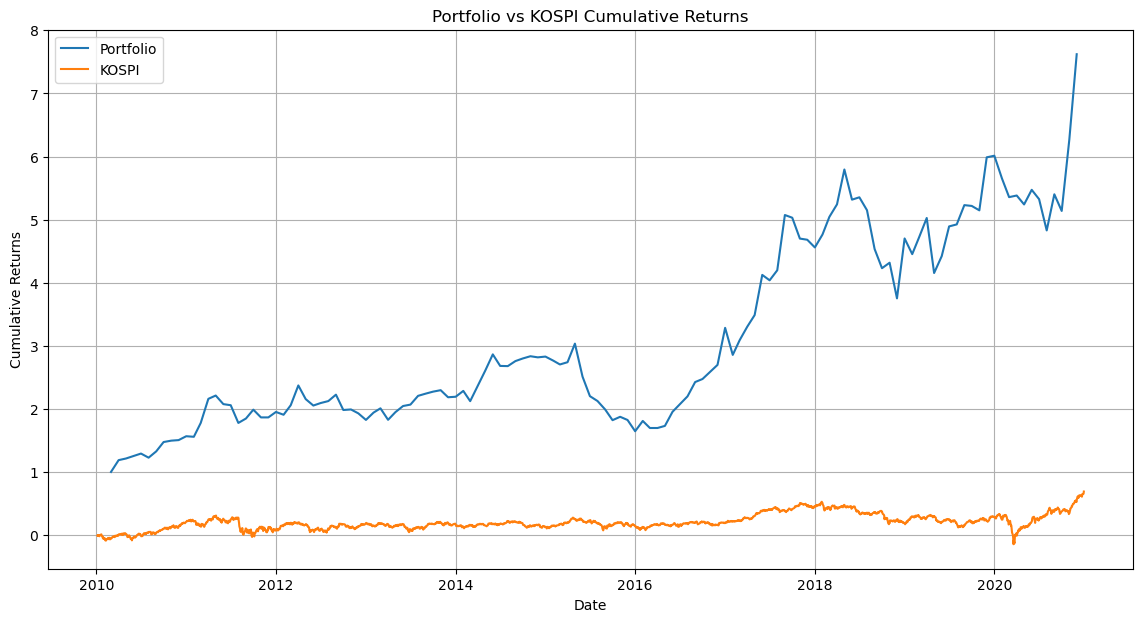

In [11]:
# Download KOSPI Index data
kospi = yf.download('^KS11', start='2010-01-01', end='2020-12-31')

# Calculate monthly cumulative returns
kospi['Monthly Returns'] = kospi['Adj Close'].pct_change()
kospi['Cumulative Returns'] = (1 + kospi['Monthly Returns']).cumprod() - 1

# Plot the cumulative returns for the portfolio and the KOSPI
plt.figure(figsize=(14,7))
plt.plot(portfolio_df.index, portfolio_df['Cumulative Returns'], label='Portfolio')
plt.plot(kospi.index, kospi['Cumulative Returns'], label='KOSPI')
plt.title('Portfolio vs KOSPI Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006089. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may

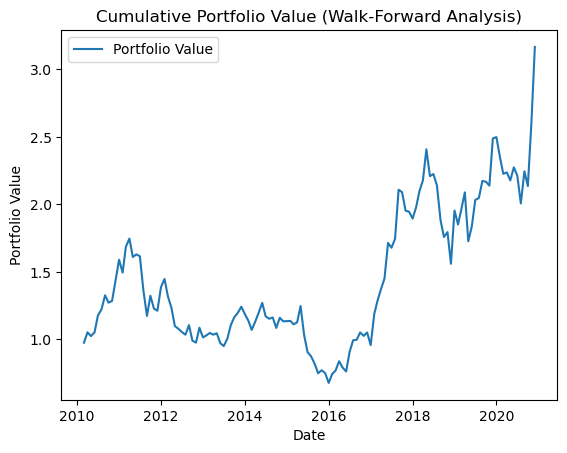

Mean Return: 0.14868595555610292
Volatility: 0.2944912899834366
Sharpe Ratio: 0.5048908426611383
Downside Deviation: 0.2467518147088687
Sortino Ratio: 0.6025728958935145
Max Drawdown: 1.069496713173402
Calmar Ratio: 0.1390242286158348


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.optimize import minimize

# Train 기간과 Test 기간 나누기
initial_train_period = 120  # 처음 10년(120개월)을 Train 데이터로 사용
step_size = 12  # 매년 Walk-Forward Test를 진행 (1년 간격)

# GARCH 모델을 사용하여 분산-공분산 행렬 계산
def garch_cov_matrix(returns):
    n_assets = returns.shape[1]
    
    # GARCH 모델로 각 자산의 분산을 추정
    variances = []
    for i in range(n_assets):
        model = arch_model(returns.iloc[:, i], vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp="off")
        variances.append(garch_fit.conditional_volatility.iloc[-1]**2)  # 마지막 분산 추정치 사용
    
    # 과거 데이터를 기반으로 상관관계 계산
    correlations = returns.corr()
    
    # 공분산 행렬 계산
    std_devs = np.sqrt(variances)
    covariance_matrix = pd.DataFrame(np.outer(std_devs, std_devs) * correlations,
                                     index=returns.columns, columns=returns.columns)
    return covariance_matrix

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율)
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 가중치 합이 1이 되어야 함
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))  # 가중치는 0에서 1 사이
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)

    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis
def walk_forward_analysis(returns, initial_train_period, step_size):
    all_weights = []
    portfolio_returns = []

    # Rolling 윈도우 방식으로 테스트 및 리밸런싱 수행
    for start in range(initial_train_period, len(returns), step_size):
        # Train 데이터는 step_size 만큼 추가됨
        train_data = returns.iloc[start-initial_train_period:start]
        test_data = returns.iloc[start:start+step_size]

        # Train 데이터로 분산-공분산 행렬과 기대 수익률 계산
        cov_matrix = garch_cov_matrix(train_data)
        expected_returns = train_data.mean()

        # 최적화된 포트폴리오 가중치 계산
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        # 테스트 데이터로 포트폴리오 수익률 계산
        portfolio_return = (test_data * weights).sum(axis=1)
        portfolio_returns.append(portfolio_return)

    # 수익률 연결
    portfolio_returns = pd.concat(portfolio_returns)

    return portfolio_returns, all_weights

# 데이터 로드 및 수익률 계산
data = pd.read_excel('stock_data_2000_2020_0.xlsx', index_col=0)
returns = data.pct_change().dropna()

# 백테스팅 실행
portfolio_returns, portfolio_weights = walk_forward_analysis(returns, initial_train_period, step_size)

# 누적 수익률 계산 및 시각화
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (Walk-Forward Analysis)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility

    # Downside Deviation 계산
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)

    # Sortino Ratio 계산
    sortino_ratio = mean_return / downside_deviation

    # Maximum Drawdown 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()

    # Calmar Ratio 계산
    calmar_ratio = mean_return / max_drawdown

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

    return metrics

# 평가 메트릭스 출력
metrics = calculate_metrics(portfolio_returns)
for key, value in metrics.items():
    print(f"{key}: {value}")

Final Code

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006089. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may

Cumulative Return: 1.2186034161827757
Annualized Return: 0.07633091961148297
Annualized Standard Deviation: 0.13421510146728807
Sharpe Ratio: -0.3382705202891441
Downside Deviation: 0.10554347225985121
Maximum Drawdown: -0.2447981998169539
Sortino Ratio: -0.1241776779568391
Calmar Ratio: -0.05353856081674788


c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003641. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008538. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may

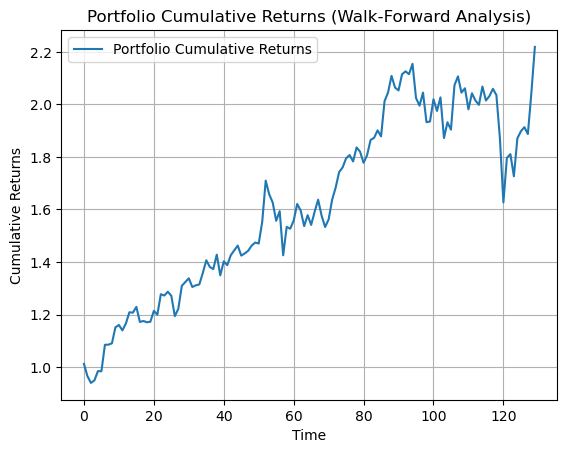

In [31]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 데이터 로드
data = pd.read_excel('stock_data_2000_2020_0.xlsx', index_col=0)

# 수익률 계산
returns = data.pct_change().dropna()

# Train 기간과 Test 기간 나누기
initial_train_period = 120  # 처음 10년(120개월)을 Train 데이터로 사용
step_size = 1  # 매월 Walk-Forward Test를 진행

# GARCH 모델을 사용하여 공분산 행렬 계산
def calculate_covariance(returns):
    # 과거 데이터를 이용하여 상관관계 계산
    correlation_matrix = returns.corr()

    # GARCH 모델을 사용하여 분산 추정
    variance_dict = {}
    for asset in returns.columns:
        model = arch_model(returns[asset], vol='Garch', p=1, q=1)
        results = model.fit(disp='off')
        variance_dict[asset] = results.conditional_volatility.iloc[-1]**2  # 최신 분산 추정치 사용

    # 분산을 데이터프레임으로 변환
    variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance'])

    # 공분산 행렬 계산
    std_dev = np.sqrt(variance_df['variance'])
    covariance_matrix = correlation_matrix.mul(std_dev, axis=0).mul(std_dev, axis=1)
    return covariance_matrix

# 글로벌 최소 분산 포트폴리오 최적화 (No Short-selling)
def min_variance_portfolio(returns):
    n = len(returns.columns)
    cov_matrix = calculate_covariance(returns)

    # Global Minimum Variance Portfolio 설정
    G = np.identity(n)
    h = np.zeros(n)
    A = np.ones((1, n))
    b = np.array([1])

    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))
    initial_weights = np.ones(n) / n

    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Walk-Forward Analysis를 사용하여 월별 리밸런싱 수행
portfolio_returns = []
current_row = 0

while current_row + initial_train_period <= len(returns) - 1:
    start_train = current_row
    end_train = current_row + initial_train_period
    train_returns = returns.iloc[start_train:end_train]
    test_return = returns.iloc[end_train]

    # Train 데이터로 글로벌 최소 분산 포트폴리오 최적화
    weights = min_variance_portfolio(train_returns)

    # 월별 포트폴리오 수익률 계산
    portfolio_return = np.dot(weights, test_return)
    portfolio_returns.append(portfolio_return)

    current_row += step_size

# 성과 평가 지표 계산
def evaluate_performance_1(returns_list, risk_free_rate):
    returns = pd.Series(returns_list)
    
    # Cumulative Return 계산
    cumulative_return = (1 + returns).cumprod().iloc[-1] - 1  # 마지막 값을 iloc[-1]로 접근
    # Annualized Return 계산
    annualized_return = ((1 + returns).prod() ** (12 / len(returns))) - 1
    # Annualized Standard Deviation 계산
    annualized_std_dev = returns.std() * np.sqrt(12)
    # Sharpe Ratio 계산
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std()

    return cumulative_return, annualized_return, annualized_std_dev, sharpe_ratio

# 수정 후 성과 평가 지표 출력
cumulative_return, annualized_return, annualized_std_dev, sharpe_ratio = evaluate_performance_1(portfolio_returns, 0.02)
print(f"Cumulative Return: {cumulative_return}")
print(f"Annualized Return: {annualized_return}")
print(f"Annualized Standard Deviation: {annualized_std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")


# 추가 성과 지표: Downside Deviation, Maximum Drawdown, Sortino Ratio, Calmar Ratio
def evaluate_performance_2(returns_list, mar):
    returns = pd.Series(returns_list)
    
    downside_returns = returns[returns < mar]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)
    
    cumulative_return = (1 + returns).cumprod()
    max_return = cumulative_return.cummax()
    drawdown = (cumulative_return - max_return) / max_return
    max_drawdown = drawdown.min()
    
    sortino_ratio = (returns.mean() - mar) / downside_deviation
    calmar_ratio = (returns.mean() - mar) / abs(max_drawdown)

    return downside_deviation, max_drawdown, sortino_ratio, calmar_ratio

downside_deviation, max_drawdown, sortino_ratio, calmar_ratio = evaluate_performance_2(portfolio_returns, 0.02)
print(f"Downside Deviation: {downside_deviation}")
print(f"Maximum Drawdown: {max_drawdown}")
print(f"Sortino Ratio: {sortino_ratio}")
print(f"Calmar Ratio: {calmar_ratio}")

# 누적 수익률 시각화
cumulative_returns = (1 + pd.Series(portfolio_returns)).cumprod()
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns')
plt.title('Portfolio Cumulative Returns (Walk-Forward Analysis)')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

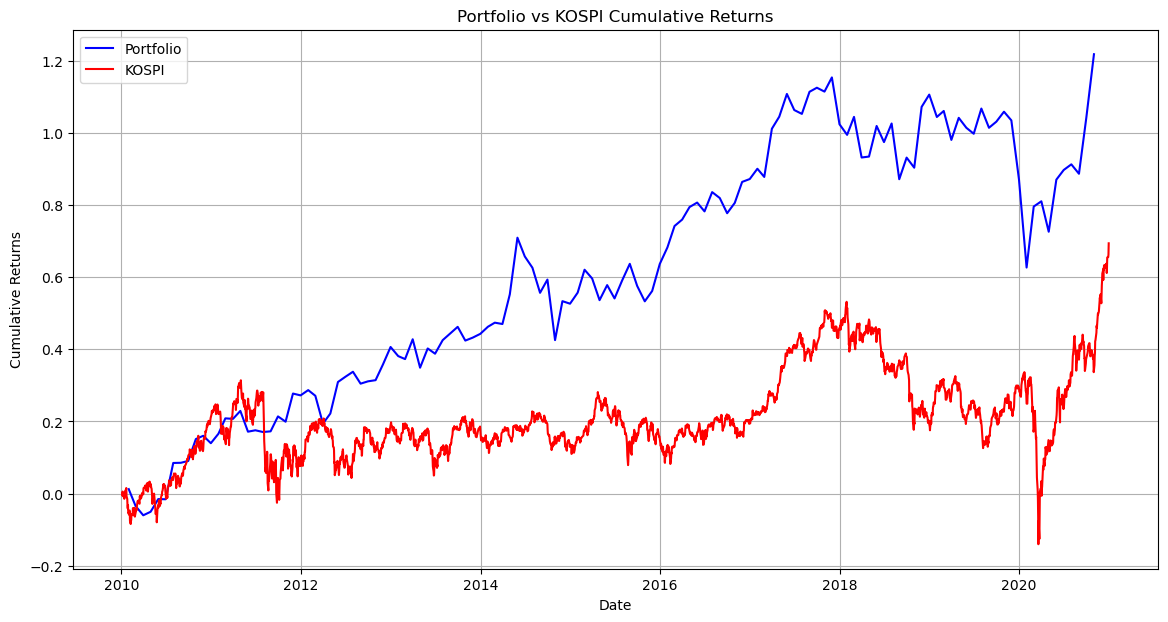

In [32]:
# 포트폴리오 누적 수익률 계산
portfolio_cumulative_returns = (1 + pd.Series(portfolio_returns)).cumprod() - 1
portfolio_cumulative_returns.index = pd.date_range(start='2010-01-01', periods=len(portfolio_cumulative_returns), freq='M')

# Download KOSPI Index data
kospi = yf.download('^KS11', start='2010-01-01', end='2020-12-31')

# Calculate monthly cumulative returns
kospi['Monthly Returns'] = kospi['Adj Close'].pct_change()
kospi['Cumulative Returns'] = (1 + kospi['Monthly Returns']).cumprod() - 1

# 포트폴리오와 KOSPI 누적 수익률 비교 그래프
plt.figure(figsize=(14, 7))
plt.plot(portfolio_cumulative_returns.index, portfolio_cumulative_returns, label='Portfolio', color='blue')
plt.plot(kospi.index, kospi['Cumulative Returns'], label='KOSPI', color='red')
plt.title('Portfolio vs KOSPI Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

Finish

In [15]:
# # Calculate Covarinace
# def calculate_covariance(returns):
#     # Calculate COrrelation using data
#     correlation_matrix = returns.corr()
    
#     # Estimate variances using GARCH(1,1)
#     n_assets = len(returns.columns)
#     variance_dict = {}
#     for asset in returns.columns:
#         model = arch_model(returns[asset], vol='GARCH', p=1, q=1, rescale=False)
#         results = model.fit(disp='off')
#         variance_dict[asset] = results.forecast(start=0).variance.iloc[-1,0]
        
#     # Convert variance_dict to DataFrame
#     variance_df = pd.DataFrame.from_dict(variance_dict, orient='index', columns=['variance'])
    
#     # Calculate the covariance matrix
#     std_dev = np.sqrt(variance_df['variance'])
#     covariance_matrix = correlation_matrix.mul(std_dev, axis=0).mul(std_dev, axis=1)
    
#     return covariance_matrix.values

# GARCH 모델을 사용한 분산-공분산 행렬 계산
def garch_cov_matrix(returns):
    n_assets = returns.shape[1]
    garch_models = []
    
    for i in range(n_assets):
        model = arch_model(returns.iloc[:, i], vol='Garch', p=1, q=1)
        garch_fit = model.fit(disp="off")
        garch_models.append(garch_fit.conditional_volatility)

    volatilities = pd.DataFrame(garch_models).T
    cov_matrix = volatilities.cov()  # 분산-공분산 행렬 계산
    return cov_matrix

In [16]:
# # Markowitz 포트폴리오 최적화
# def portfolio_optimization(cov_matrix, expected_returns):
#     def objective(weights):
#         return np.dot(weights.T, np.dot(cov_matrix, weights))

#     # 제약 조건: 가중치 합은 1이어야 함
#     constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#     bounds = tuple((0, 1) for _ in range(len(expected_returns)))  # 가중치는 0과 1 사이
#     initial_weights = np.array(len(expected_returns) * [1. / len(expected_returns)])  # 초기 가중치

#     result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
#     return result.x

# Markowitz 포트폴리오 최적화 함수 (최대 샤프 비율)
def portfolio_optimization(cov_matrix, expected_returns, risk_free_rate=0.02):
    def sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - risk_free_rate) / portfolio_volatility  # 최대화 문제를 최소화로 변경

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 가중치 합은 1
    bounds = tuple((0, 1) for _ in range(len(expected_returns)))  # 가중치 0과 1 사이 # No Short-selling
    initial_weights = np.ones(len(expected_returns)) / len(expected_returns)
    
    result = minimize(sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [17]:
# 평가 메트릭스 계산
def calculate_metrics(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12
    volatility = portfolio_returns.std() * np.sqrt(12)
    sharpe_ratio = mean_return / volatility

    # Downside Deviation 계산
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(12)

    # Sortino Ratio 계산
    sortino_ratio = mean_return / downside_deviation

    # Maximum Drawdown 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = running_max - cumulative_returns
    max_drawdown = drawdown.max()

    # Calmar Ratio 계산
    calmar_ratio = mean_return / max_drawdown

    metrics = {
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Downside Deviation": downside_deviation,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio
    }

    return metrics

In [18]:
# # 백테스팅 (Train 세트로 최적화된 가중치로 Test 세트에서 성과 측정)
# train_cov_matrix = garch_cov_matrix(train_returns)
# train_expected_returns = train_returns.mean()

# # 최적화된 포트폴리오 가중치 계산
# optimal_weights = portfolio_optimization(train_cov_matrix, train_expected_returns)

# # Test 세트에서 월간 리턴 계산
# test_portfolio_returns = (test_returns * optimal_weights).sum(axis=1)

# # 포트폴리오 누적 수익 계산
# cumulative_returns = (1 + test_portfolio_returns).cumprod()

# 6. 백테스팅 및 리밸런싱
def backtest_portfolio(train_returns, test_returns):
    train_cov_matrix = garch_cov_matrix(train_returns)
    train_expected_returns = train_returns.mean()

    # 포트폴리오 최적화: 최대 샤프 비율
    optimal_weights = portfolio_optimization(train_cov_matrix, train_expected_returns)

    # Test 기간 동안 포트폴리오 성과 측정 (월간 리밸런싱)
    portfolio_returns = (test_returns * optimal_weights).sum(axis=1)

    # 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # 포트폴리오 가치 그래프
    plt.plot(cumulative_returns, label='Portfolio Value')
    plt.title('Cumulative Portfolio Value (2010-2020)')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

    # 평가 메트릭스 출력
    metrics = calculate_metrics(portfolio_returns)
    for key, value in metrics.items():
        print(f"{key}: {value}")

    return portfolio_returns

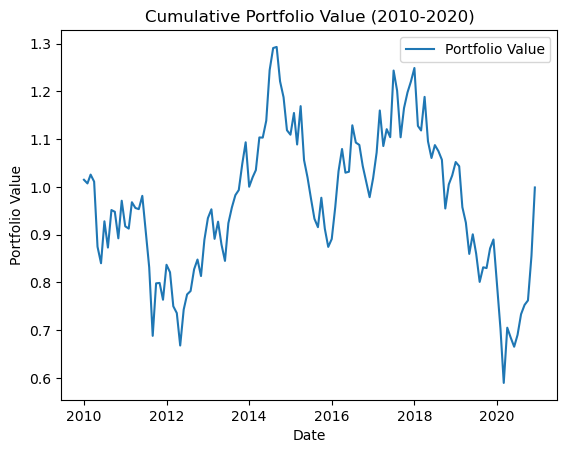

In [13]:
# # 포트폴리오 수익률 그래프
# plt.plot(cumulative_returns, label='Portfolio Value')
# plt.title('Cumulative Portfolio Value (2010-2020)')
# plt.xlabel('Date')
# plt.ylabel('Portfolio Value')
# plt.legend()
# plt.show()

In [14]:
# # 평가 메트릭스 계산 (평균 수익률, 표준편차, 샤프 비율 등)
# mean_return = test_portfolio_returns.mean() * 12
# volatility = test_portfolio_returns.std() * np.sqrt(12)
# sharpe_ratio = mean_return / volatility

# # 평가 메트릭스 출력
# print("Mean Return:", mean_return)
# print("Volatility (Std):", volatility)
# print("Sharpe Ratio:", sharpe_ratio)

Mean Return: 0.025187506679949824
Volatility (Std): 0.2259329856126947
Sharpe Ratio: 0.1114822017318333


c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may 

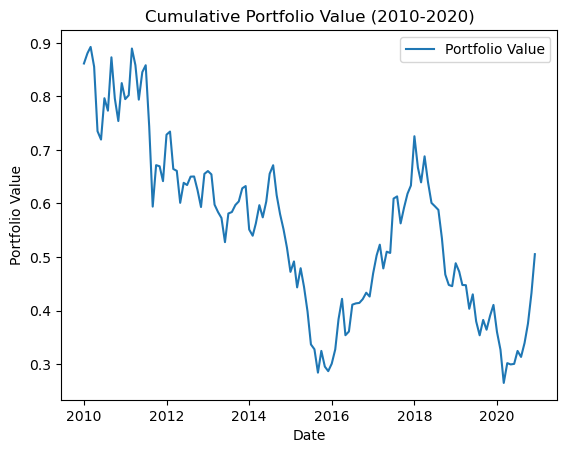

Mean Return: -0.020578432414030366
Volatility: 0.28782831032492145
Sharpe Ratio: -0.07149551199741241
Downside Deviation: 0.28328339761859705
Sortino Ratio: -0.0726425642555179
Max Drawdown: 0.6277360104336238
Calmar Ratio: -0.032781984898102814


In [19]:
portfolio_returns = backtest_portfolio(train_returns, test_returns)

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.009844. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may 

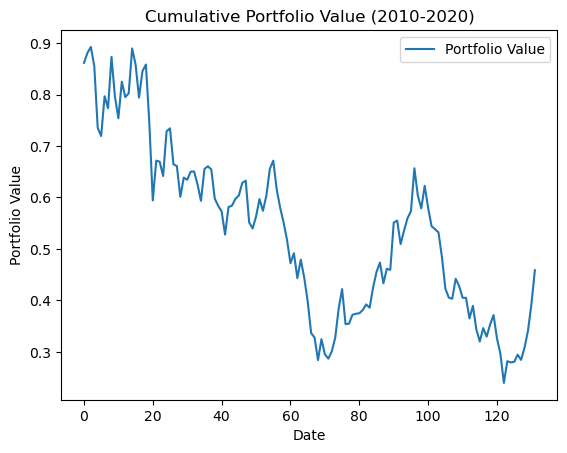

In [20]:
def walk_forward_analysis(train_returns, test_returns):
    all_weights = []
    portfolio_returns = []

    for i in range(len(test_returns)):
        # 각 월마다 새로운 데이터 추가
        current_train_returns = pd.concat([train_returns, test_returns.iloc[:i]])
        
        # 해당 기간의 분산-공분산 행렬 계산
        cov_matrix = garch_cov_matrix(current_train_returns)
        expected_returns = current_train_returns.mean()
        
        # 포트폴리오 최적화
        weights = portfolio_optimization(cov_matrix, expected_returns)
        all_weights.append(weights)

        # 월별 포트폴리오 수익률 계산
        portfolio_return = np.dot(weights, test_returns.iloc[i])
        portfolio_returns.append(portfolio_return)

    return np.array(portfolio_returns), np.array(all_weights)

# 6. 백테스팅 실행
portfolio_returns, portfolio_weights = walk_forward_analysis(train_returns, test_returns)

# 7. 포트폴리오 가치 그래프
cumulative_returns = (1 + portfolio_returns).cumprod()
plt.plot(cumulative_returns, label='Portfolio Value')
plt.title('Cumulative Portfolio Value (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()